In [109]:
import torch
import math
import operator as op

def pure_hashmap_update(d, k, v):
    if isinstance(k, torch.Tensor):
        k = k.item()
    d2 = d.copy()
    d2.update({k:v})
    return d2
    

# inspired by https://norvig.com/lispy.html
def eval_env():
	env = {}
	env.update({
		'+': op.add,
       	'-': op.sub,
        '*': op.mul,
        '/': op.truediv,
        '>': op.gt,
        '<': op.lt,
        '>=': op.ge,
        '<=': op.le, 
        '=': op.eq,
        'sqrt': torch.sqrt,
        'vector': lambda *x: torch.tensor(x),
        'hash-map': lambda *x : dict(zip([i.item() if isinstance(i, torch.Tensor) else i for i in x[::2]], x[1::2])),
        'get': lambda x, y: x[y.long()] if isinstance(x, torch.Tensor) else x[y.item() if isinstance(y, torch.Tensor) else y],
        'put': lambda x, y, z: torch.cat((x[:y.long()], torch.tensor([z]), x[y.long()+1:])) if isinstance(x, torch.Tensor) else pure_hashmap_update(x,y,z),
        'append' : lambda x, y: torch.cat((x, torch.tensor([y]))),
        'first' : lambda x: x[0],
        'last' : lambda x: x[-1],
        'remove': lambda x, y : torch.cat((x[:y.long()], x[y.long()+1:])) if isinstance(x, torch.Tensor) else {i:x[i] for i in x if i != y},
        'normal': torch.distributions.Normal,
        'beta': torch.distributions.beta.Beta,
        'exponential': torch.distributions.exponential.Exponential,
        'uniform': torch.distributions.uniform.Uniform,
        'bernoulli': torch.distributions.bernoulli.Bernoulli,
        'discrete': lambda *x: torch.distributions.categorical.Categorical(torch.tensor(x)) 
        })


	return env

In [110]:
ENV = None

def evaluate_program(ast, return_sig=False):
    """Evaluate a program as desugared by daphne, generate a sample from the prior
    Args:
        ast: json FOPPL program
    Returns: sample from the prior of ast
    """
    global ENV
    ENV = eval_env()
    for defn in ast[:-1]:
        f_name = defn[1]
        f_v_is = defn[2]
        f_expr = defn[3]
        ENV.update({f_name: (f_v_is, f_expr)})
    l = {}
    ret, sig = evaluate(ast[-1], l)
    return (ret, sig) if return_sig else ret

# inspired by https://norvig.com/lispy.html
def evaluate(e, l, sig=None):
    # variable reference OR procedure OR just a string
    if isinstance(e, str):        
        # global procedures take precedence over locally defined vars
        if e in ENV:
            return ENV[e], sig
        elif e in l:
            return l[e], sig
        # allows for hashmaps with string keys
        else:
            return e
    # constant number
    elif isinstance(e, (int, float)):   
        return torch.tensor(float(e)), sig
    # if statements
    elif e[0] == 'if':
        (_, test, conseq, alt) = e
        exp = (conseq if evaluate(test, l)[0] else alt)
        return evaluate(exp, l)
    # let statements
    elif e[0] == 'let':
        # get symbol
        symbol = e[1][0]
        # get value of e1
        value, _ = evaluate(e[1][1], l)
        # evaluate e2 with value 
        return evaluate(e[2], {**l, symbol: value})
    # sample statement
    if e[0] == 'sample':
        dist = evaluate(e[1], l)[0]
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        return dist.sample(), sig
    # procedure call, either primitive or user-defined
    else:
        proc, sig = evaluate(e[0], l)
        # primitives are functions
        if callable(proc):
            args = [evaluate(arg, l)[0] for arg in e[1:]]
            result, sig = proc(*args), sig
            return result, sig
        # user defined functions are not
        else:
            # as written in algorithm 6
            v_is, e0 = proc 
            assert(len(v_is) == len(e[1:]))
            c_is = [evaluate(arg, l)[0] for arg in e[1:]]
            l_proc = dict(zip(v_is, c_is))
            return evaluate(e0, {**l, **l_proc})

In [119]:
evaluate_program([['sample', ['normal', 5, ['sqrt', 2]]]])

tensor(5.8329)

In [120]:
my_samples = []
for i in range(10000):
    my_samples.append(evaluate_program([['defn', 'get-sig', ['var'], ['*', 'var', 'var']], ['sample', ['normal', 0, ['get-sig', 1.2]]]]))

In [121]:
their_samples = []
import math
dist = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.2*1.2))


In [122]:
for i in range(10000):
    their_samples.append(dist.sample())

In [123]:
import matplotlib.pyplot as plt

(array([   5.,   69.,  352., 1306., 2766., 2990., 1756.,  646.,  101.,
           9.]),
 array([-5.907432  , -4.7663736 , -3.6253154 , -2.4842572 , -1.3431989 ,
        -0.20214057,  0.93891776,  2.079976  ,  3.2210343 ,  4.3620925 ,
         5.503151  ], dtype=float32),
 <BarContainer object of 10 artists>)

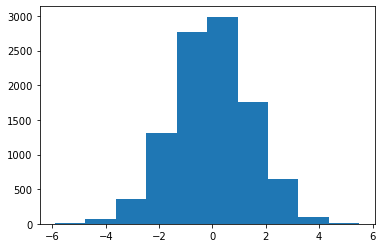

In [124]:
plt.hist(torch.tensor(my_samples).numpy())

(array([  13.,  116.,  514., 1409., 2421., 2725., 1878.,  729.,  172.,
          23.]),
 array([-5.356398  , -4.3165536 , -3.276709  , -2.2368643 , -1.1970198 ,
        -0.1571753 ,  0.88266927,  1.9225138 ,  2.9623585 ,  4.002203  ,
         5.0420475 ], dtype=float32),
 <BarContainer object of 10 artists>)

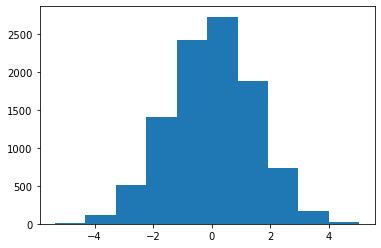

In [125]:
plt.hist(torch.tensor(their_samples).numpy())

In [118]:
[['let', ['z', ['sample', ['uniform', 0, 1]]],
  ['let', ['mu', ['if', ['<', 'z', 0.1], -1, 1]],
   ['sample', ['normal', 'mu', ['sqrt', 0.09]]]]]]

[['let',
  ['z', ['sample', ['uniform', 0, 1]]],
  ['let',
   ['mu', ['if', ['<', 'z', 0.1], -1, 1]],
   ['sample', ['normal', 'mu', ['sqrt', 0.09]]]]]]